In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_percentage_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import math

data = pd.read_csv('LABS-LAGGED.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d')
data.set_index('Timestamp', inplace=True)

# Drop the original DayOfWeek column
data.drop(columns=['DayOfWeek','HSW-COD-load','HSW-COD-load_1', 'HSW-COD-load_2', 'HSW-COD-load_3', 'HSW-COD-load_4',
                  'HSW-COD-load_5', 'HSW-COD-load_6', 'Dig-stability', 'Biogas_6', 'TWAS-VS-load_2', 'PS-VS-load_3'
                  , 'PS-VS-load_5', 'PS-VS-load_6', 'TWAS-VS-load_4','TWAS-VS-load_3','SRT','PS-VS-load_1','HSW-VS-load_2'
                  , 'Biogas_4','HSW-VS-load_5','PS-VS-load','Biogas_3','PS-VS-load_2','TWAS-VS-load_5','TWAS-VS-load_6'
                  , 'PS-VS-load_4', 'Biogas_2','HSW-VS-load_3','HSW-VS-load_4','TWAS-VS-load','TWAS-VS-load_1','BOD-load'], inplace=True)

cv=TimeSeriesSplit(gap = 5)

In [2]:
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(
    data.drop('Forecast', axis=1), data['Forecast'], test_size=0.2,
    shuffle=False)

# Initialize scaler object
scaler = StandardScaler()

# Fit the scaler on the training dataset, but we have to exclude the sine and cosine terms
scaler.fit(x_train)

# Transform the training and testing dataset
x_train_s = pd.DataFrame(scaler.transform(x_train), index=x_train.index)
x_test_s = pd.DataFrame(scaler.transform(x_test), index=x_test.index)

# Add the column names back
x_train_s.columns = x_train.columns
x_test_s.columns = x_test.columns


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

random_seed=1
# Initialize Model
model_ann = MLPRegressor(max_iter=400,
                          early_stopping=True,
                          random_state=random_seed,
                          #hidden_layer_sizes=(20,7),
                          #solver='sgd',
                          #learning_rate='adaptive',
                          #alpha=0.01,
                         )
# Create a 'grid' of ANN model fitting parameters to explore
param_grid = {
    'hidden_layer_sizes': [ (2,), (6,), (10,), (15,), (4,2), (6,3), (8,4), (10,5), (10,2), (20,2), (65,2), (20,5), (65,5), (20,10), (65,10)],
    'alpha': [0.01,0.1, 1,5,10,20,30,40, 50,100,500],
    'learning_rate': ['invscaling', 'adaptive'],
    'solver': ['sgd', 'adam']
}

grid_search = GridSearchCV(model_ann,
                           param_grid,
                           cv=cv,
                           scoring='neg_mean_absolute_percentage_error',
                           n_jobs=-1,
                           )

# Conduct a 'grid search' for the 'best' model
grid_search.fit(x_train_s.values, y_train)

# Print the best results
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)


In [ ]:
best_model = grid_search.best_estimator_
y_train_ann = best_model.predict(x_train_s.values)
y_test_ann = best_model.predict(x_test_s.values)


mse_train_ann = mean_squared_error(y_train, y_train_ann)
mape_train_ann = mean_absolute_percentage_error(y_train, y_train_ann)
r2_train_ann = r2_score(y_train, y_train_ann)
rmse_train = math.sqrt(mse_train_ann)
mse_test_ann = mean_squared_error(y_test, y_test_ann)
mape_test_ann = mean_absolute_percentage_error(y_test, y_test_ann)
r2_test_ann = r2_score(y_test, y_test_ann)
rmse_test = math.sqrt(mse_test_ann)

# Print training and testing error
print(f"Training Mean Squared Error (MSE): {round(mse_train_ann,3)}")
print(f"Training Root Mean Squared Error (MSE): {round(rmse_train,3)}")
print(f"Training R-squared (R2) Score: {round(r2_train_ann,3)}")
print(f"Training Mean Absolute Percentage Error (MAPE): {round(mape_train_ann,3)}")
print(f"Testing Mean Squared Error (MSE): {round(mse_test_ann,3)}")
print(f"Testing Root Mean Squared Error (MSE): {round(rmse_test,3)}")
print(f"Testing R-squared (R2) Score: {round(r2_test_ann,3)}")
print(f"Testing Mean Absolute Percentage Error (MAPE): {round(mape_test_ann,3)}")

def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

n = len(x_test_s)  # Number of samples in test data
k = len(x_train_s.columns) # Number of predictors in the model

# Calculate Adjusted R-squared
adjusted_r2_value = adjusted_r2(r2_train_ann, n, k)
print("Adjusted R-squared train:", round(adjusted_r2_value,3))
adjusted_r2_value_te = adjusted_r2(r2_test_ann, n, k)
print("Adjusted R-squared test:", round(adjusted_r2_value_te,3))
print("Number of variables:",k)
TeEI = (mape_test_ann*mape_test_ann*rmse_test)/adjusted_r2_value_te
print("TeEI:", round(TeEI,3))

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error
# Set the random seed
random_seed = 1

model_ann1 = MLPRegressor(max_iter=200,
                          early_stopping=True,
                          random_state=random_seed,
                          hidden_layer_sizes=(20,7),
                          solver='sgd',
                          learning_rate='adaptive',
                          alpha=74)
# Fit the model
#x_train_s = x_train_s.values
model_ann1.fit(x_train_s.values, y_train)

num_parameters = sum(param.size for param in model_ann1.coefs_)
print("Number of parameters:", num_parameters)

#x_test_s = x_test_s.values

y_train_ann1 = model_ann1.predict(x_train_s.values)
y_test_ann1 = model_ann1.predict(x_test_s.values)

# Calculate training and testing error
mse_train_ann1 = mean_squared_error(y_train, y_train_ann1)
mape_train_ann1 = mean_absolute_percentage_error(y_train, y_train_ann1)
rmse_train = math.sqrt(mse_train_ann1)
r2_train_ann1 = r2_score(y_train, y_train_ann1)
mse_test_ann1 = mean_squared_error(y_test, y_test_ann1)
mape_test_ann1 = mean_absolute_percentage_error(y_test, y_test_ann1)
r2_test_ann1 = r2_score(y_test, y_test_ann1)
rmse_test = math.sqrt(mse_test_ann1)

# Print training and testing error
print(f"Training Mean Squared Error (MSE): {round(mse_train_ann1,3)}")
print(f"Training Root Mean Squared Error (MSE): {round(rmse_train,3)}")
print(f"Training Mean Absolute Percentage Error (MAPE): {round(mape_train_ann1,3)}")
print(f"Training R-squared (R2) Score: {round(r2_train_ann1,3)}")
print(f"Testing Mean Squared Error (MSE): {round(mse_test_ann1,3)}")
print(f"Testing Root Mean Squared Error (MSE): {round(rmse_test,3)}")
print(f"Testing Mean Absolute Percentage Error (MAPE): {round(mape_test_ann1,3)}")
print(f"Testing R-squared (R2) Score: {round(r2_test_ann1,3)}")

def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

n = len(x_test_s)  # Number of samples in test data
k = len(x_train_s.columns)  # Number of predictors in the model

# Calculate Adjusted R-squared
adjusted_r2_value = adjusted_r2(r2_test_ann1, n, k)
print("Adjusted R-squared test:", round(adjusted_r2_value,3))
adjusted_r2_value_tr = adjusted_r2(r2_train_ann1, n, k)
print("Adjusted R-squared train:", round(adjusted_r2_value_tr,3))
print("Number of variables:",k)
TEI = (mape_test_ann1*mape_test_ann1*rmse_test)/adjusted_r2_value
print("TEI:", round(TEI,3))

Number of parameters: 267
Training Mean Squared Error (MSE): 502.361
Training Root Mean Squared Error (MSE): 22.413
Training Mean Absolute Percentage Error (MAPE): 0.396
Training R-squared (R2) Score: 0.7
Testing Mean Squared Error (MSE): 547.029
Testing Root Mean Squared Error (MSE): 23.389
Testing Mean Absolute Percentage Error (MAPE): 0.265
Testing R-squared (R2) Score: 0.651
Adjusted R-squared test: 0.641
Adjusted R-squared train: 0.692
Number of variables: 6
TEI: 2.565


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


  0%|          | 0/218 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


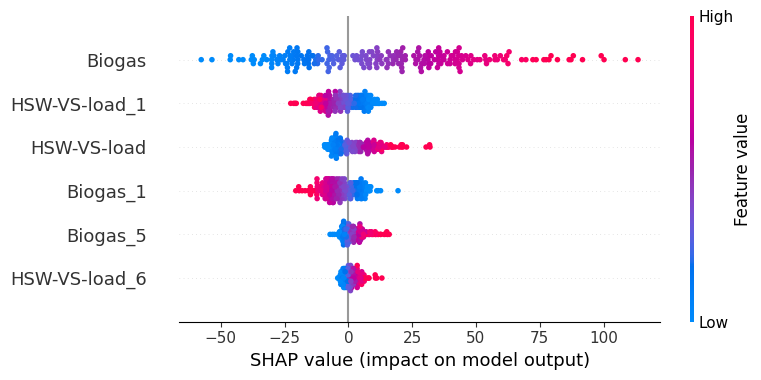

In [6]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import shap
import time

shap.initjs()

X_train_summary = shap.kmeans(x_train_s, 10)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(model_ann1.predict, X_train_summary)
shap_values = explainer.shap_values(x_test_s)
shap.summary_plot(shap_values, x_test_s, feature_names=x_test_s.columns)

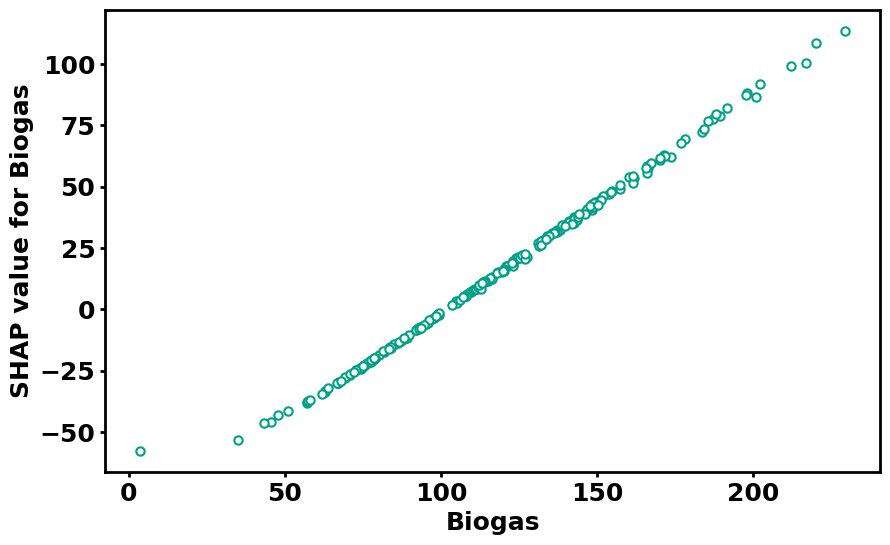

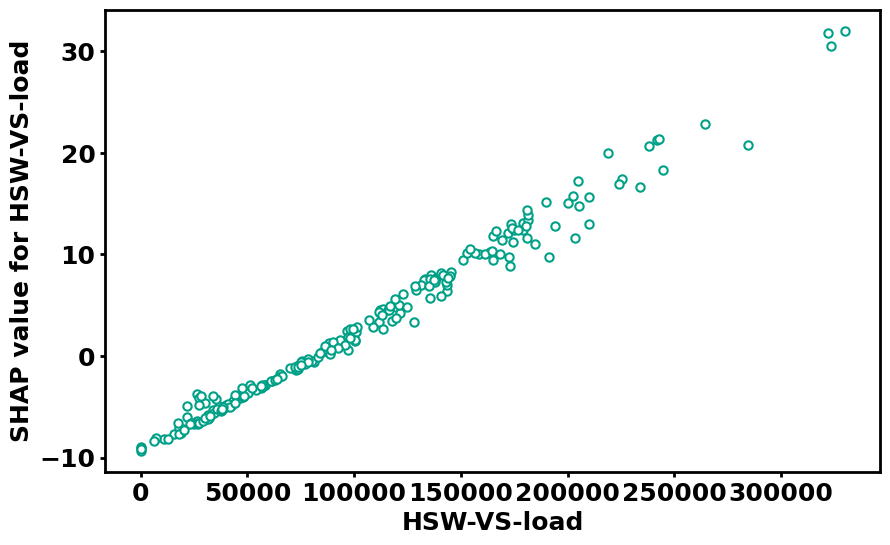

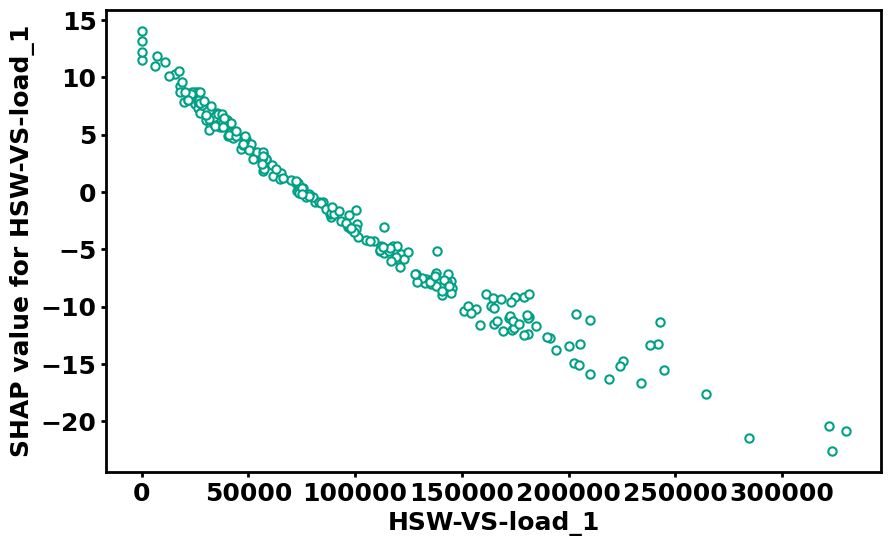

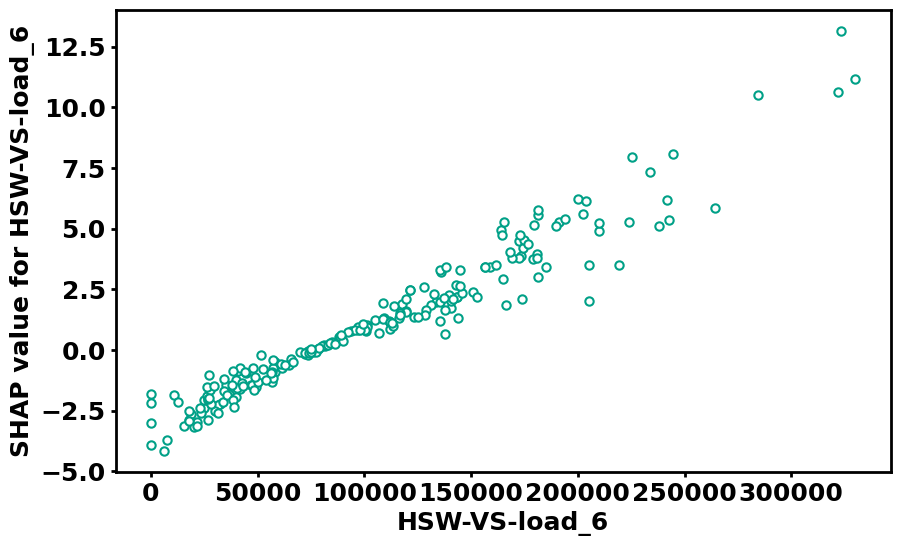

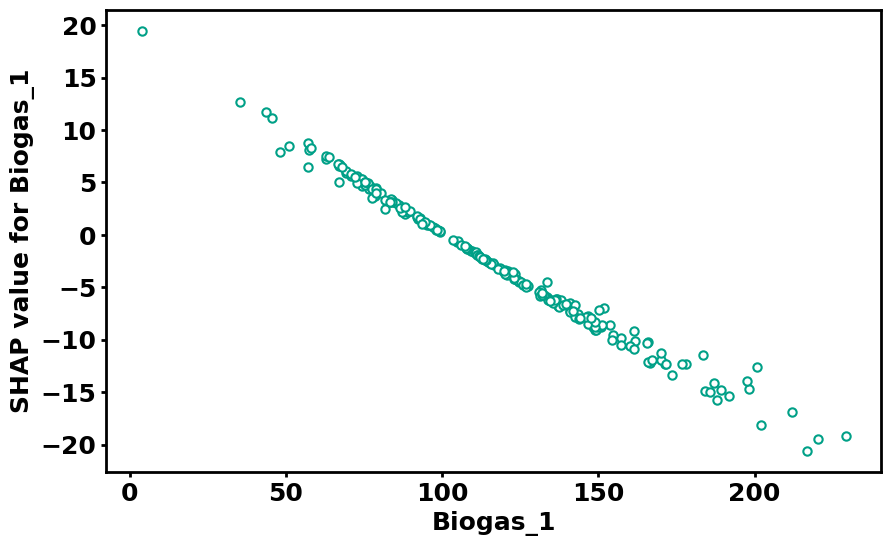

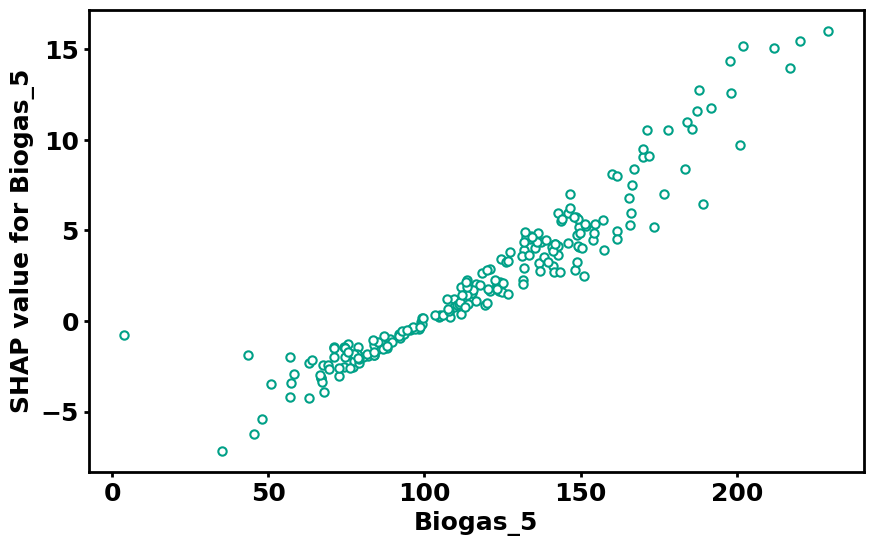

In [7]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_props = FontProperties(family='DejaVu Sans', weight='bold',size=18)

for feature_index in range(len(x_test.columns)):
    try:
        fig, ax = plt.subplots(figsize=(10, 6), frameon=True)

        # Convert testing_features to a NumPy array
        testing_features_array = np.array(x_test)

        # Scatter plot of SHAP values vs. testing_features
        scatter = ax.scatter(
            testing_features_array[:, feature_index],
            shap_values[:, feature_index],
            marker='o',
            edgecolors='#00A087FF',
            facecolors='w',
            linewidths=1.5
        )

        # Set plain rectangular frame
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
        # Set x-axis label
        ax.set_xlabel(x_train_s.columns[feature_index], fontproperties=font_props)

        # Set y-axis label
        ax.set_ylabel(f"SHAP value for {x_train_s.columns[feature_index]}", fontproperties=font_props)

        # Reformat tick label fonts
        ax.tick_params(axis='both', which='both', labelsize=12, width=2)
        
        # Apply font_props to tick labels
        for label in ax.get_xticklabels():
            label.set_fontproperties(font_props)
        for label in ax.get_yticklabels():
            label.set_fontproperties(font_props)
        plt.savefig(f"plot_{feature_index}.png", bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error creating plot for feature {feature_index}: {e}")


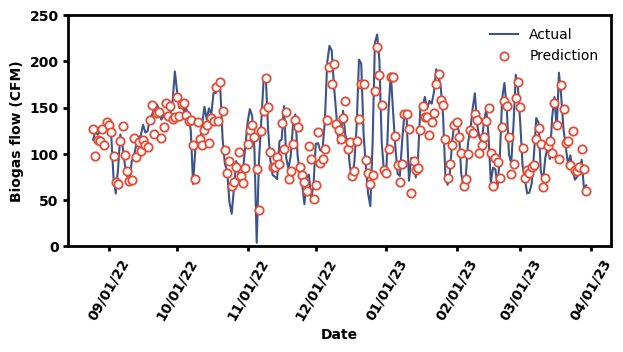

In [8]:
from matplotlib.font_manager import FontProperties
import matplotlib.dates as mdates

font_props = FontProperties(family='DejaVu Sans', weight='bold')

fig = plt.figure(figsize=(7, 3))

# Define the desired index range
start_index = 871
end_index = 1103

x = data.index[start_index:end_index]
y1 = data['Forecast'][start_index:end_index]  # Forecast
y2 = np.concatenate((y_train_ann1, y_test_ann1))[start_index:end_index]

plt.yticks(fontproperties=font_props)
plt.xticks(rotation=60,fontproperties=font_props)
plt.plot(x, y1, c='#3C5488FF', label='Actual',zorder=1)
plt.scatter(x,y2,marker='o', edgecolors='#E64B35FF', linewidths=1.3, facecolors='w', label='Prediction',zorder=2)
plt.xlabel('Date', fontproperties=font_props); plt.ylabel('Biogas flow (CFM)', fontproperties=font_props); 
plt.ylim(0, 250)  # Set y-axis limits
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D'))
plt.legend(frameon=False)

plt.gca().xaxis.set_tick_params(width=2)
plt.gca().yaxis.set_tick_params(width=2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)

plt.savefig("Fig3C.png", bbox_inches='tight')
plt.show()


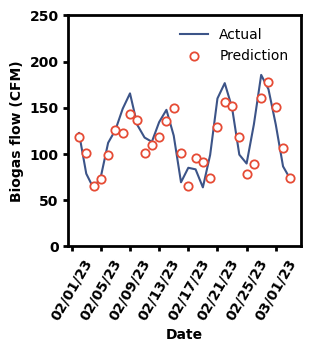

In [15]:
from matplotlib.font_manager import FontProperties

font_props = FontProperties(family='DejaVu Sans', weight='bold')

fig = plt.figure(figsize=(3, 3))

# Define the desired index range
start_index = 1032
end_index = 1062

x = data.index[start_index:end_index]
y1 = data['Forecast'][start_index:end_index]  # Forecast
y2 = np.concatenate((y_train_ann1, y_test_ann1))[start_index:end_index]
y3 = data['Biogas'][start_index:end_index]
plt.yticks(fontproperties=font_props)
plt.xticks(rotation=60,fontproperties=font_props)
plt.plot(x, y1, c='#3C5488FF', label='Actual',zorder=1)
plt.scatter(x,y2,marker='o', edgecolors='#E64B35FF', linewidths=1.3, facecolors='w', label='Prediction',zorder=2)
#plt.plot(x,y2, c='#E64B35FF', label='Prediction',zorder=3)
#plt.plot(x,y3, c='#3C5488FF', label='Persistence',zorder=2)
plt.xlabel('Date', fontproperties=font_props); plt.ylabel('Biogas flow (CFM)', fontproperties=font_props); 
plt.ylim(0, 250)  # Set y-axis limits
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D'))
plt.legend(frameon=False)

plt.gca().xaxis.set_tick_params(width=2)
plt.gca().yaxis.set_tick_params(width=2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.savefig("Fig3D.png", bbox_inches='tight')
plt.show()